In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Setup


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
%load_ext tensorboard
os.chdir("/content/drive/MyDrive/Pancreas_Segmentation_Project")
dataset_path = "/content/drive/MyDrive/Pancreas_Segmentation_Project/Task07_Pancreas"
home_path = "/content/drive/MyDrive/Pancreas_Segmentation_Project/Task07_Pancreas"

In [4]:
!pip install simpleitk
!pip install -q "monai[gdown, nibabel, tqdm]"
!pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-ignite
!pip install itk

     |████████████████████████████████| 47.4MB 115kB/s 
     |████████████████████████████████| 358kB 12.6MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 776.8MB 19kB/s 
     |████████████████████████████████| 12.8MB 29.2MB/s 
     |████████████████████████████████| 7.6MB 61.6MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
     |████████████████████████████████| 204kB 6.6MB/s 
     |████████████████████████████████| 36.3MB 141kB/s 
     |████████████████████████████████| 50.1MB 117kB/s 
     |████████████████████████████████

In [5]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    ThresholdIntensityd,
    RandAffined,
    NormalizeIntensityd
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import (compute_meandice,
                           get_confusion_matrix, 
                           compute_roc_auc, 
                           ConfusionMatrixMetric,
                           compute_hausdorff_distance,
                           compute_average_surface_distance
                           )
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import SimpleITK as sitk  
import numpy as np 

In [6]:
print_config()

MONAI version: 0.4.0
Numpy version: 1.19.5
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.0.0
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Setup Dataset

In [7]:
# For  8:1:1 train/val/test split
root_dir = dataset_path
data_dir = dataset_path
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
num_train = int(np.floor(len(data_dicts)*0.80))
num_val = int(np.floor(len(data_dicts)*0.90))
test_files, val_files = data_dicts[num_val:], data_dicts[num_train:num_val]

In [8]:
set_determinism(seed=0)

In [9]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ThresholdIntensityd(keys=["label"],
                            threshold=0.5,
                            above = False,
                            cval = 1),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-100, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        NormalizeIntensityd(keys=["image"]),
        ToTensord(keys=["image", "label"]),
    ]
)

In [10]:
test_ds = CacheDataset(
    data=test_files, transform=val_transforms,
    cache_rate=0.1, num_workers=1)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=0.1, num_workers=1)

# In case the RAM is limited, following commands can construct standard dataset

# test_ds = Dataset(data=test_files, transform=val_transforms)
# val_ds = Dataset(data=val_files, transform=val_transforms)

test_loader = DataLoader(test_ds, batch_size=2, shuffle=True, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


# Check Dataset

image shape: torch.Size([252, 203, 105]), label shape: torch.Size([252, 203, 105])


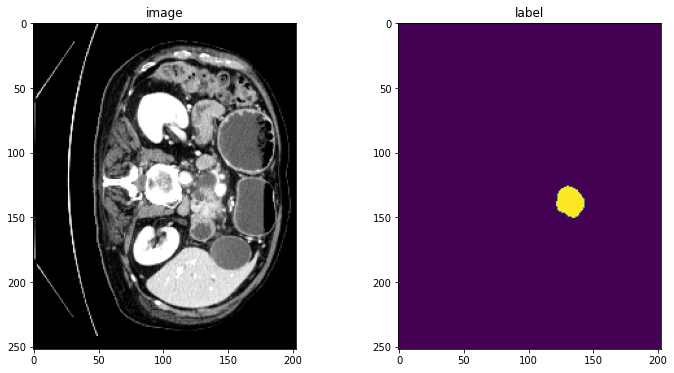

In [11]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 40])
plt.show()

# Helper functions

In [12]:
def save_checkpoint(epoch,avg_loss,prec,model,opt, filename='checkpoint.pth.tar'):
    state = {
            'epoch': epoch + 1,
            'avg_loss': avg_loss,
            'state_dict': model,
            'best_prec1': prec,
            'optimizer' : opt,
        }
    torch.save(state, filename) 

# Create model

In [13]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512,1024),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


# Load Model

In [14]:
val_interval = 2
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)
save_dir = os.path.join(root_dir,'saving')

In [16]:
loadname = "Unet_best_metric_model_large_2.pth.tar"
checkpoint = torch.load(os.path.join(save_dir, loadname))
model.load_state_dict(checkpoint['state_dict'])
epoch_loss_values = checkpoint['avg_loss']
metric_values = checkpoint['best_prec1']
del checkpoint

# Visualization of training loss and validation accuracy

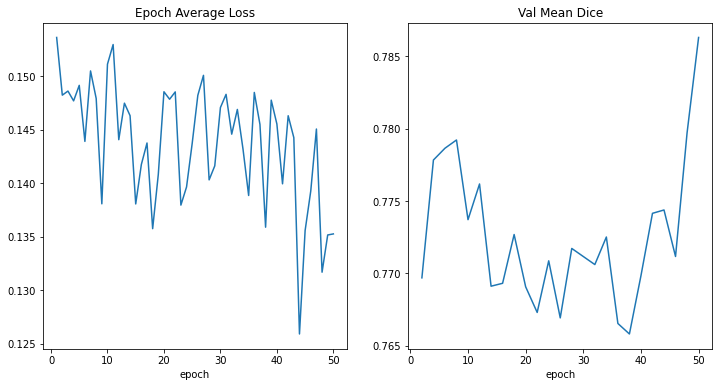

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Inference

In [18]:
def get_stat_metric(matrix):
    TP = matrix[0][0][0]
    FP = matrix[0][0][1]
    TN = matrix[0][0][2]
    FN = matrix[0][0][3]
    sensitivity = TP/(TP+FN)
    precision = TP/(TP+FP)
    return sensitivity, precision

In [19]:
model.eval()
with torch.no_grad():
    metric_sum = 0.0
    metric_count = 0
    sensitivity = 0
    precision = 0
    hausdorff = 0
    ASdistance = 0
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 2
        val_outputs = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_outputs = post_pred(val_outputs)
        val_labels = post_label(val_labels)
        value = compute_meandice(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False,
        )
        matrix = get_confusion_matrix(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False,
        )
        metric_count += len(value)
        metric_sum += value.sum().item()
        sens,prec = get_stat_metric(matrix)
        hausdorff += compute_hausdorff_distance(
            y_pred=val_outputs,
            y=val_labels,
        )
        ASdistance += compute_average_surface_distance(
            y_pred=val_outputs,
            y=val_labels,
        )
        sensitivity+= sens
        precision += prec
    
    metric = metric_sum / metric_count
    sensitivity = sensitivity/metric_count
    precision = precision/metric_count
    hausdorff = hausdorff/metric_count
    ASdistance = ASdistance/metric_count
print(metric)
print(sensitivity)
print(precision)
print(hausdorff)
print(ASdistance)

0.7863084652594158
tensor(0.7916, device='cuda:0')
tensor(0.8047, device='cuda:0')
tensor([[15.6692]], dtype=torch.float64)
tensor([[1.3856]], dtype=torch.float64)


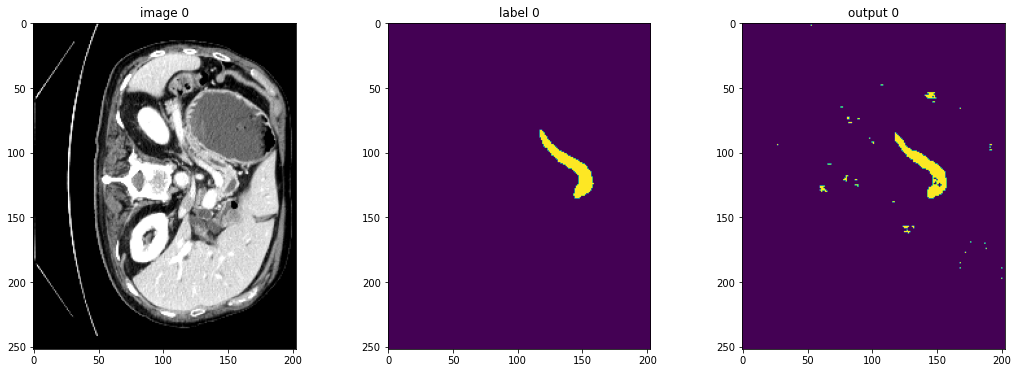

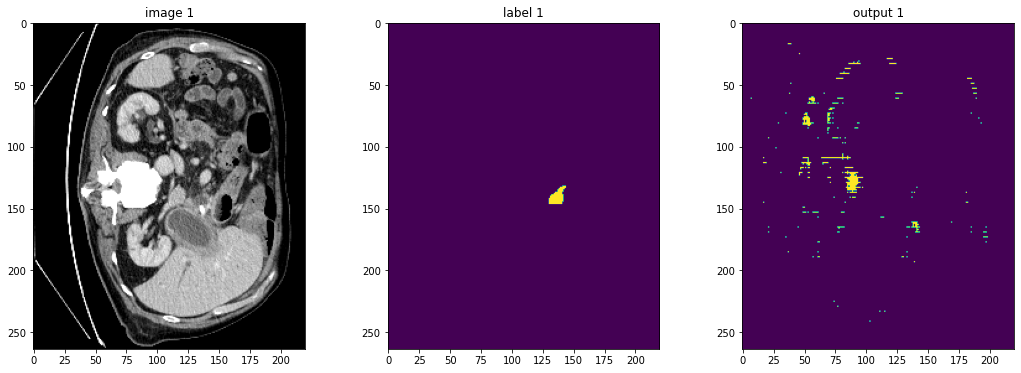

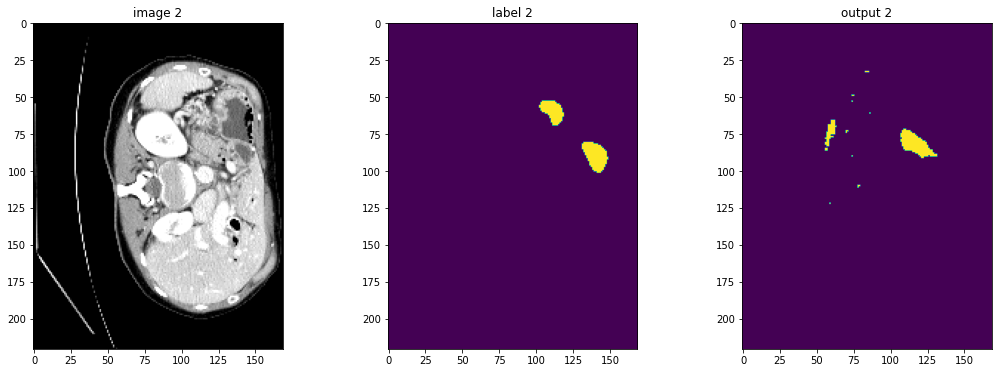

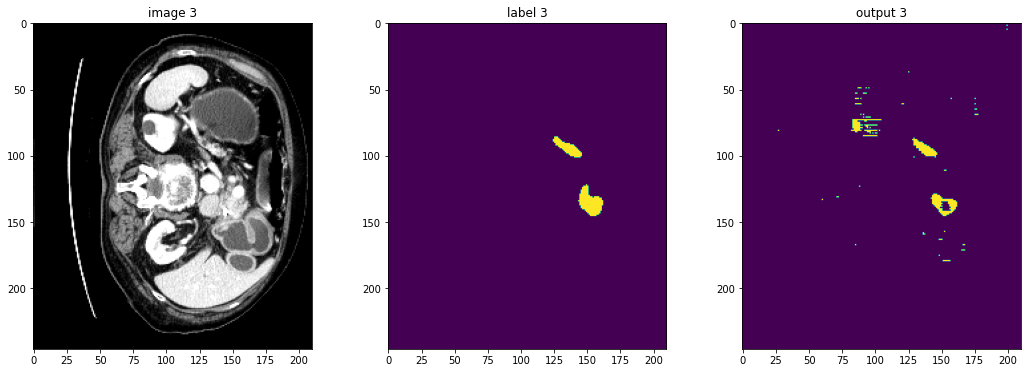

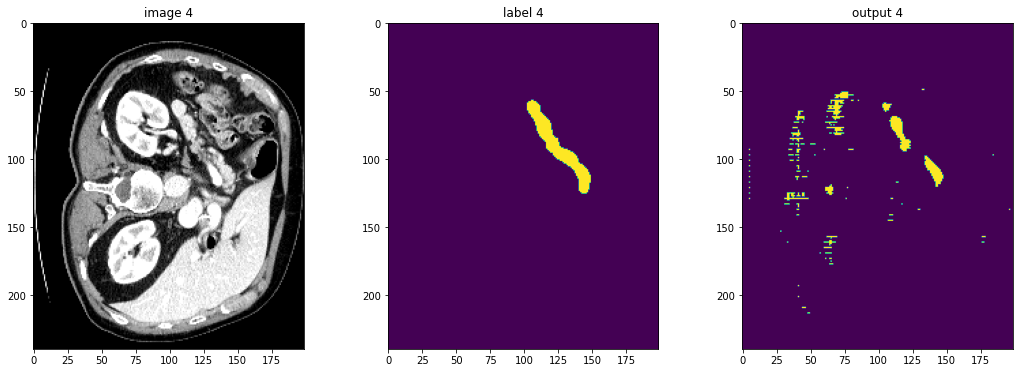

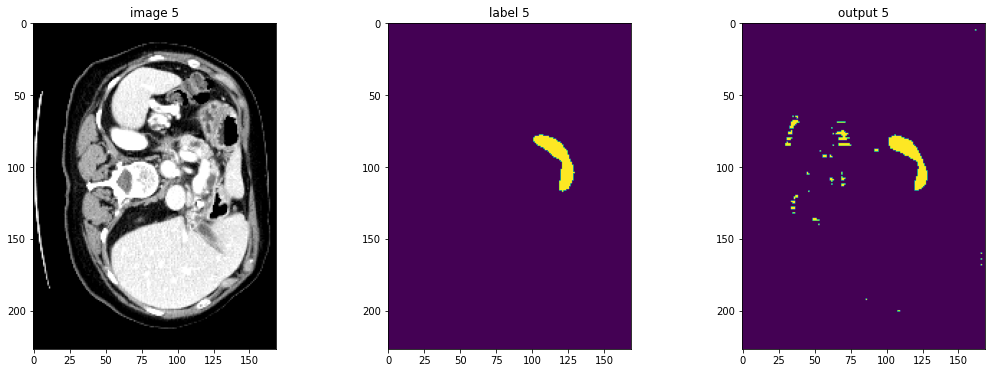

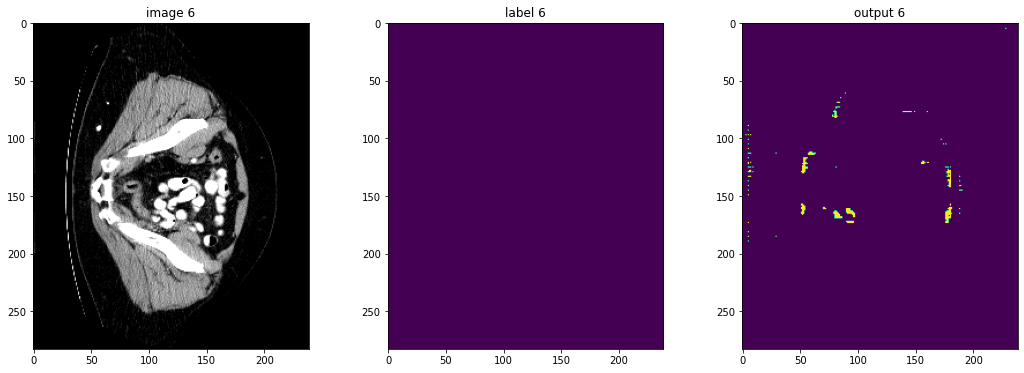

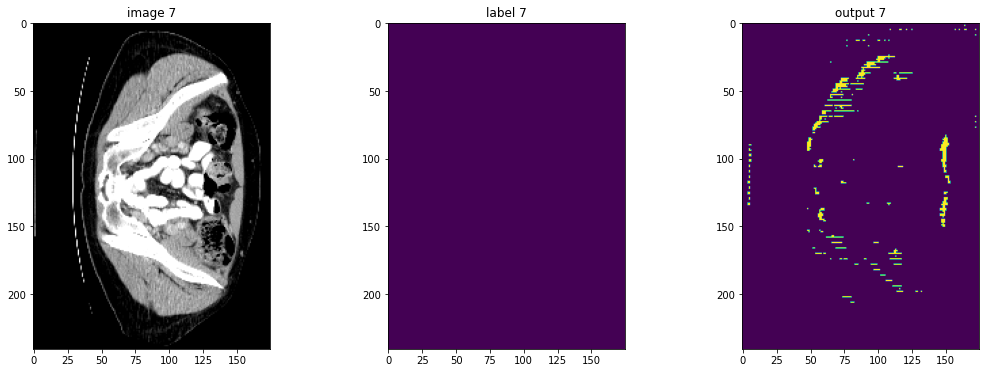

KeyboardInterrupt: ignored

In [21]:
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 60], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 60])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 60])
        plt.show()
